# Predicting phases of Rydberg-atom systems under longer adiabatic state preparation times  with Conditional Generative Models

Haoxiang Wang (hwang264@illinois.edu)

Work done as an applied scientist intern at Amazon Braket in 2022

In [1]:
import sys
# to read modules from the parent directory
sys.path.insert(0,'..')
root = '../'

In [2]:
import numpy as np
import pickle
from time import time
from joblib import Parallel, delayed
from src.models.mlp import MLP
from src.eval import RydbergEvaluator
from src.eval.eval_rydberg import est_density_from_z_measurements,est_corr_from_z_measurements,determine_phase_1D,est_order_param_1D,phase2img,est_phase_diagram,est_order_param_1D_fourier_from_measurements,est_order_param_1D_fourier,fourier_transform_square_lattice,est_order_param_2D_from_measurements
from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid
import argparse
from constants import *
from src.training.rydberg_trainers import RydbergConditionalTransformerTrainer
from src.models.transformer import init_conditional_transformer
from src.models.mlp import MLP
from src.eval.eval_rydberg import determine_phase_1D,determine_phase_2D,est_order_param_1D,est_order_param_2D
from src.utils import plot_phase_diagram

import torch
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm,trange
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Rydberg Hamiltonian
This example is about trapped Rydberg atoms, a class of highly controllable neural atoms that can be used to build programmable Ising-type quantum simulators \cite{Rydberg-spin-liquids,Rydberg1D-51atoms,Rydberg2D-256atoms}. In Ising-type quantum simulations, a Rydberg atom is effectively considered as a two-level system consisting of a ground state $| g \rangle$ (i.e., $|0\rangle$) and a highly-excited state $ | r\rangle$ (i.e., $|1 \rangle$) called Rydberg state. Rydberg atoms can be allocated on a plane and trapped by light tweezers. In \cite{Rydberg1D-51atoms}, Rydberg atoms are placed along a 1D lattice (i.e., a chain) equidistantly, while \cite{Rydberg2D-256atoms} allocates the atoms as a 2D square lattice. For either a 1D or 2D lattice of Rydberg atoms, denoting the nearest-neighbor distance of atoms $a$, the Hamiltonian of such a system can be described by
\begin{align}\label{eq:H-rydberg}
    H=\frac{\Omega}{2} \sum_{i} X_{i}-\Delta \sum_{i} N_{i}+\sum_{i<j}\left(\frac{V_{0}}{|\vec x_i- \vec x_j|}\right)^{6} N_{i} N_{j} ~,
\end{align}
where $\Omega$ is the Rabi frequency, $\Delta$ is the detuning of laser, $R_b$ is a constant, $\vec x_i$ is the location vector of the qubit $i$, and $N_i$ is the occupation number operator at site $i$, i.e., $N_i = |{r_i}\rangle \langle {r_i} |$


## Approximate Ground States via Adiabatic Evolution

The many-body ground state of a Rydberg Hamiltonian is typically obtained via \textit{adiabatic evolution}. 
Initially, each Rydberg atom is prepared in its ground state $|0\rangle$ (with high precision) such that the many-body state is $|0\dots 0\rangle$, which is the ground state of the Rydberg Hamiltonian with a large negative detuning $\Delta$ and zero-valued $\Omega$. Then, the detuning strength $\Delta$ is ramped up gradually to positive values, while the Rabi frequency is turned on (i.e., $\Omega > 0$). Clearly, the Hamiltonian of the Rydberg system is time-dependent according to a custom scheduler for $\Delta$ and $\Omega$. By the Adiabatic Theorem of quantum mechanics, we know as the time evolution process is slow enough, the quantum state of the system always stays closes to the ground state of the time-dependent Hamiltonian at any time step. Therefore, as the evolution process is sufficiently slow, we can end up with a prepared state that is approximately the ground state of the final Hamiltonian. 

## Load Simulation Results of Adiabatic Evolution

We conducted classical simulations for the adiabatic evolution of 2D Rydberg systems using [Bloqade.jl](https://github.com/QuEraComputing/Bloqade.jl/). The code for the simulation is presented in `rydberg/`.

Below, we load simulation data stored in `data/rydberg`.
+ For each simulation run of adiabatic evolution, we initiate a Rydberg lattice with a custom atom separation (i.e., $a$ in the Hamiltonian), and tune $\Delta, \Omega$ according to a preset scheduler. We take multiple time steps across the evolution, performing meausurements in the Z-basis, and save the measurement data locally.


In [3]:
meta_datasets = {}
nx,ny=5,5
n_qubits = nx*ny
dim = 2
assert dim == 2
# meta_dataset.info['striated'].describe()
order_params = ['Checkboard','Striated','Staggered']
n_gen_samples = 1000

base_kwargs = {'nx':nx, 
              'ny':ny}
f_order_param = est_order_param_1D_from_measurements if dim == 1 else est_order_param_2D_from_measurements
all_ts = np.arange(0.4,3.05,0.2)
all_ts = np.round(all_ts,6)
all_ts = np.unique(all_ts)
threshold = 0.65

for total_time in tqdm(all_ts):
    folder = root+f'data/rydberg/2D-Phase_{nx}x{ny}/{float(np.round(total_time,2))}µs/'
    meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=20, var_name='interaction_range',
                                              ) 
    meta_dataset.est_order_params(order_params=order_params,est_from_measurements=True)
    meta_dataset.info['phase'] = determine_phase_2D(meta_dataset.info,order_params,threshold=threshold)
    meta_datasets[total_time] = meta_dataset

  0%|          | 0/14 [00:00<?, ?it/s]

In [4]:
def get_plot_df(meta_dataset,order_params=order_params,threshold=threshold):
    df = meta_dataset.info.copy()
    if not ('phase' in df.columns):
        df['phase'] = determine_phase_2D(df, order_params,threshold=threshold)
    plot_df = df.iloc[np.isin(df['interaction_range'].values, np.unique(df['interaction_range'].unique())[::2])]
    plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] > 1)]
    return plot_df

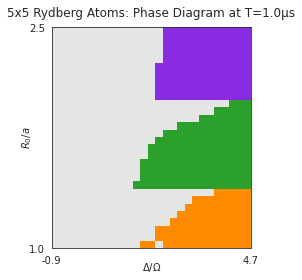

In [5]:
hue_order = ['Disordered']+order_params
sns.set_style('white')
t = 1.
df = meta_datasets[t].info.copy()
plot_df = df.iloc[np.isin(df['interaction_range'].values, np.unique(df['interaction_range'].unique())[::2])]
plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] > 1)]
fig = plot_phase_diagram(plot_df,title=f"{nx}x{ny} Rydberg Atoms: Phase Diagram at T={t}μs",
                         hue_order=hue_order,figsize=(4,4))

## Prepare Training Set

We split the phase diagram by grids (defined by `x_bins` and `y_bins`), and sample one point in each grid for training. Each point represents the ground state of one quantum system with the corresponding variables ($a,\Delta,\Omega$).

In [6]:

def prepare_train_set(meta_dataset, df=None, n_measurements:int = -1, x_bins=10,y_bins=10):
    train_set = {}
    if df is None: df = meta_dataset.info
    train_idxes, train_df = unif_sample_on_grid(df.copy(),x_bins=x_bins,y_bins=y_bins)#,x_range=(0.4,1.78),y_range=(1.4,2.4))
    # train_idxes = plot_df.index.values
    train_keys = meta_dataset.keys[train_idxes]
    train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set, train_idxes
def prepare_dataset(meta_datasets,train_times:list,n_measurements:int = 1000,):
    train_set = {}
    densities = []
    for t in train_times:
        meta_dataset = meta_datasets[t]
        df = meta_dataset.info
        train_keys = meta_dataset.keys[df.index]
        train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set

In [7]:
train_ts = all_ts[(all_ts >=0.4) * (all_ts <= 1.0)]
train_set = prepare_dataset(meta_datasets,train_times=train_ts,n_measurements=-1)
test_ts = all_ts[all_ts > 1]

In [8]:
# You can save them locally and reload later

# np.save('logs/rydberg_2D/train_idxes.npy',train_idxes)
# pickle.dump(train_set, open('logs/rydberg_2D/train_set.pkl','wb'))
# pickle.dump(meta_dataset, open('logs/rydberg_2D/meta_dataset.pkl','wb'))

## Train a Conditional Generative Model

We first define some hyperparameters as follows

In [9]:
def parse_args(args=[]):
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='logs/rydberg/debug/')
    parser.add_argument('--dim',type=int,default=1)
    parser.add_argument('--nx',type=int,default=19)
    parser.add_argument('--ny',type=int,default=1)
    parser.add_argument('--tf-arch', type=str, default='transformer_l4_d128_h4')
    parser.add_argument('--train-id', type=str, default="debug")
    parser.add_argument('--reps', type=int, default=1)
    parser.add_argument('--ns', type=int, default=800, help='number of samples per hamiltonian')
    parser.add_argument('--iterations', type=int, default=200000, help="training iterations")
    parser.add_argument('--eval-every', type=int, default=100)
    parser.add_argument('--eval-samples', type=int, default=10000, help='number of generated samples for evaluation')
    parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
    parser.add_argument('--verbose', type=int, default=1, choices=[0, 1])
    parser.add_argument('--epoch-mode', type=int, default=1, choices=[0, 1])
    parser.add_argument('--condition-mode', type=int, default=0, choices=[0, 1])
    parser.add_argument('--seed', type=int, default=None)
    return parser.parse_args(args)


def get_hyperparams(**kwargs):
    hparams = argparse.Namespace(
        lr=1e-3,
        wd=0,
        bs=512,
        dropout=0.0,
        lr_scheduler=WARMUP_COSINE_SCHEDULER,
        warmup_frac=0.,
        final_lr=1e-7,
        smoothing=0.0,
        use_padding=0,
        val_frac=0.25,
        cattn=0
    )

    for k, v in kwargs.items():
        setattr(hparams, k, v)

    return hparams
args = parse_args()
hparams = get_hyperparams()

In [10]:
num_outcomes = 2 # for rydberg systems

n_vars = len(list(train_set.keys())[0])
gpu_idx = 3
device = torch.device(f"cuda:{gpu_idx}")

rng = np.random.default_rng(seed=args.seed)
# setup transformer
d_model = TF_ARCHS[args.tf_arch]['d_model']
n_head = TF_ARCHS[args.tf_arch]['n_head']
n_layers = TF_ARCHS[args.tf_arch]['n_layers']
assert d_model % n_head == 0, 'd_model must be integer multiple of n_head!'

We construct a MLP (fully-connected net) as the encoder and a transformer as the generative model, and then train the model

In [11]:
encoder = MLP(input_size=n_vars, output_size=d_model, 
              n_layers=1, hidden_size=128, activation='ELU', 
              input_layer_norm=False,
              output_batch_size=None, device=device,
             output_factor=1.)

transformer = init_conditional_transformer(
        n_outcomes=num_outcomes,
        encoder=encoder,
        n_layers=n_layers,
        d_model=d_model,
        d_ff=4 * d_model,
        n_heads=n_head,
        dropout=hparams.dropout,
        version=hparams.use_padding,
        use_prompt=False, #***
)

trainer = RydbergConditionalTransformerTrainer(model=transformer,
                                  train_dataset=train_set,
                                  test_dataset=None,
                                  iterations=args.iterations,
                                  lr=hparams.lr,
                                  final_lr=hparams.final_lr,
                                  lr_scheduler=hparams.lr_scheduler,
                                  warmup_frac=hparams.warmup_frac,
                                  weight_decay=hparams.wd,
                                  batch_size=hparams.bs,
                                  rng=rng,
                                  smoothing=hparams.smoothing,
                                  eval_every=args.eval_every,
                                  transfomer_version=hparams.use_padding,
                                  device=device)

In [12]:
load_pretrained = True

In [13]:

model_name = f'transformer_{train_ts.min()}-{train_ts.max()}_iter-{args.iterations//1000}k'
if load_pretrained:
    ckpt_path = root + f'logs/rydberg_2D-time/{model_name}.pth'
    transformer = torch.load(ckpt_path)
    transformer.to(device)
    transformer.device = device
    print(f'Loaded trained model from {ckpt_path}')
else:
    trainer.train()
    torch.save(transformer,root + f'logs/rydberg_2D-time/{model_name}.pth') # You can save the trained model

Loaded trained model from ../logs/rydberg_2D-time/transformer_0.4-1.0_iter-200k.pth


For each $T$, we use the conditional generative model to generate `n_gen_samples` measurements for each point in its phase diagram, and then determine the phase by order parameters.

In [14]:
dfs_CGM = {}
for t in tqdm(all_ts):
    meta_dataset = meta_datasets[t]
    plot_df = get_plot_df(meta_dataset)
    n_gen_samples = 1000
    test_df = plot_df.copy()
    test_df[order_params] = np.nan
    densities = {}
    transformer.eval()
    n_qubits = nx*ny
    torch.manual_seed(0) # Set seed to ensure reproduction
    torch.cuda.manual_seed(0)
    for idx in tqdm(test_df.index,desc="Generation",leave=False):
        key = meta_dataset.keys[idx]
        condition = torch.from_numpy(np.array([key])).float()
        gen_samples = transformer.sample_batch(cond_var=condition,batch_size=n_gen_samples,
                                                   num_qubits=n_qubits)
        density = gen_samples.mean(axis=0)
        densities[idx] = density
        for order_param in order_params:
            test_df.loc[idx, order_param] = est_order_param_2D_from_measurements(gen_samples,order_param=order_param,
                                                                                 nx=nx,ny=ny)
    test_df['phase'] = determine_phase_2D(test_df,order_params,threshold=threshold)
    dfs_CGM[t] = test_df.copy()
            # test_df.loc[idx, order_param] = est_order_param_2D(density,order_param=order_param,nx=nx,ny=ny)

In [15]:
# You can save the results locally & reload it later
# pickle.dump(dfs_CGM, open(root+'logs/rydberg_2D-time/dfs_CGM.pkl','wb'))
# dfs_CGM = pickle.load(open(root+'logs/rydberg_2D-time/dfs_CGM.pkl','rb'))

In [16]:
def compute_acc(pred_df,true_df,idxes=None):
    idxes = idxes or pred_df.index.values
    pred_df = pred_df.loc[idxes]
    true_df = true_df.loc[idxes]
        
    V = pred_df['phase'].values == true_df['phase'].values
    clf_acc = np.mean(V)
    return clf_acc
def compute_rmse(pred_df,true_df,order_params=order_params,idxes=None):
    idxes = idxes or pred_df.index.values
    pred_df = pred_df.loc[idxes]
    true_df = true_df.loc[idxes]# make sure both dfs have the same order     
    error = np.mean((pred_df[order_params].values - true_df[order_params].values)**2)
    return np.sqrt(error)

In [17]:
from src.models.kernels import build_dirichlet_kernel,build_NTK
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

In [18]:
train_keys = list(train_set.keys())
f_label = est_order_param_1D_from_measurements if dim == 1 else est_order_param_2D_from_measurements # labelling function (density --> label)
Xs,Xs_test,Ys,Ys_test = [],[],[],[]
for key, measurements in tqdm(list(train_set.items())):
    x = np.array(key)
    density = np.mean(measurements,axis=0)
    y = [f_label(measurements,order_param=order_param,**base_kwargs) for order_param in order_params]
    # y = density
    Xs.append(x)
    Ys.append(y)
Xs,Ys = np.array(Xs),np.array(Ys)

  0%|          | 0/7680 [00:00<?, ?it/s]

In [19]:
scaler = MinMaxScaler()#Normalizer()
Xs = scaler.fit_transform(Xs)

In [20]:
meta_dataset = meta_datasets[3.0]
plot_df = get_plot_df(meta_dataset)
idxes = plot_df.index.values
Xs_test = scaler.transform(meta_dataset.keys[idxes])
# Ys_test = [meta_dataset[idx]['density_z'] for idx in test_idxes]#meta_dataset.info[order_params].values
Ys_test = plot_df[order_params].values

In [21]:
train_dirichlet_kernel = build_dirichlet_kernel(Xs)
test_dirichlet_kernel = build_dirichlet_kernel(Xs_test)

In [22]:
C = 1e5
clf_dir = KernelRidge(kernel='linear',alpha=1/(2*C)).fit(train_dirichlet_kernel,Ys)

In [23]:
pred_dirichlet = clf_dir.predict(test_dirichlet_kernel)
err_dirichlet = np.sqrt(np.mean((pred_dirichlet - Ys_test)**2))

In [24]:
err_dirichlet

0.2324116272240672

In [25]:
C = 10
clf_rbf = KernelRidge(kernel='rbf',alpha=1/(2*C)).fit(Xs,Ys)

In [26]:
pred_rbf = clf_rbf.predict(Xs_test)
err_rbf = np.sqrt(np.mean((pred_rbf - Ys_test)**2))

In [27]:
err_rbf

0.24354545477625483

In [29]:
# We found the GPU version of Jax doesn't give stable NTK results when the regularization is very small, 
# i.e., the coefficient C is large.
# So we let Jax to run on CPU only when computing the NTK
import os 
os.environ["JAX_PLATFORM_NAME"] = "cpu"
ntk_train, ntk_pred_fn, ntk_kernel_fn = build_NTK(Xs,Ys,C=1,layers=3, # more layers --> worse results
                                                  normalize=False,activation='Erf',
                                                  return_kernel_fn=True)

In [30]:
C_ntk = 100
pred_ntk, ntk_test = ntk_pred_fn(Xs_test,C=C_ntk,return_kernel=True)
err_ntk = np.sqrt(np.mean((pred_ntk - Ys_test)**2))

In [31]:
err_ntk

0.2052808536259051

In [32]:
dfs_rbf,dfs_ntk,dfs_dir = {},{},{}
for t in tqdm(all_ts):
    meta_dataset = meta_datasets[t]
    plot_df = get_plot_df(meta_dataset)
    for order_param in order_params:
        plot_df[order_param] = np.nan
    keys = meta_dataset.keys[plot_df.index.values]
    xs = scaler.transform(keys)

    df = plot_df.copy()
    df[order_params] = clf_rbf.predict(xs)
    df['phase'] = determine_phase_2D(df,order_params,threshold)
    df_rbf = df.copy()

    df = plot_df.copy()
    df[order_params] = clf_dir.predict(build_dirichlet_kernel(xs))
    df['phase'] = df['phase'] = determine_phase_2D(df,order_params,threshold)
    df_dir = df.copy()

    df = plot_df.copy()
    df[order_params] = ntk_pred_fn(xs,C=C_ntk)
    df['phase'] = df['phase'] = determine_phase_2D(df,order_params,threshold)
    df = df.sort_values(['phase'])
    df_ntk = df.copy()
    
    dfs_rbf[t] = df_rbf 
    dfs_ntk[t] = df_ntk
    dfs_dir[t] = df_dir


  0%|          | 0/14 [00:00<?, ?it/s]

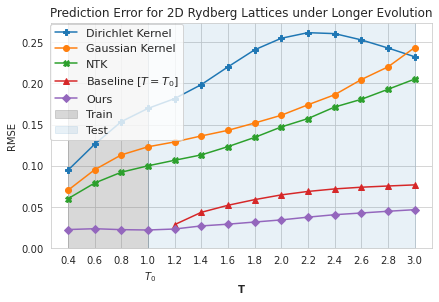

In [33]:
fig = plt.figure(figsize=(6.2,4.3))
sns.set_style('whitegrid')
ts = all_ts
plt.plot(ts,[compute_rmse(dfs_dir[t], get_plot_df(meta_datasets[t])) for t in ts],'-P',label='Dirichlet Kernel')
plt.plot(ts,[compute_rmse(dfs_rbf[t], get_plot_df(meta_datasets[t])) for t in ts],'-o',label='Gaussian Kernel')
plt.plot(ts,[compute_rmse(dfs_ntk[t], get_plot_df(meta_datasets[t])) for t in ts],'-X',label='NTK')
plt.plot(test_ts,[compute_rmse(get_plot_df(meta_datasets[1.]), get_plot_df(meta_datasets[t])) for t in test_ts],'-^',
         label=r'Baseline [$T=T_0]$')
plt.plot(ts,[compute_rmse(dfs_CGM[t], get_plot_df(meta_datasets[t])) for t in ts],'-D',label='Ours')
plt.xticks(ts)
plt.title('Prediction Error for 2D Rydberg Lattices under Longer Evolution')
plt.xlabel('$T_0$                                                     \nT',fontweight='bold')
plt.ylabel('RMSE')
plt.ylim(-.0,)
ax = plt.gca()
ax.fill_between(ts, 0, 0.28, where=(ts >= 0.4) & (ts <= 1.0), alpha=0.3,label='Train',color='tab:gray')
ax.fill_between(ts, 0, 0.28, where=(ts >= 1.0), alpha=0.1,label='Test',color='tab:blue')
plt.legend(loc='upper left',bbox_to_anchor=(-.015,1.02),fontsize=11.1)
plt.tight_layout()
# plt.savefig(root+'figs/paper/2D-time_error-curve.png',dpi=200)
# plt.savefig(root+'figs/paper/2D-time_error-curve.pdf')

In [34]:
t = 3.
sns.set_style('white')
legend_config = {'loc':'center left','bbox_to_anchor':(-.025,0.5),'fontsize':11.3}
figsize=(3.8,3.8)

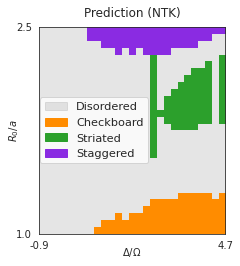

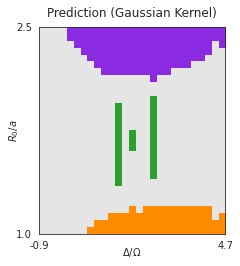

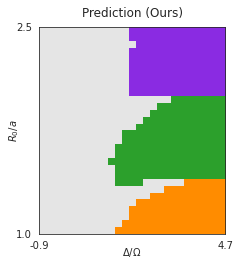

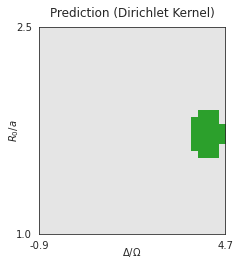

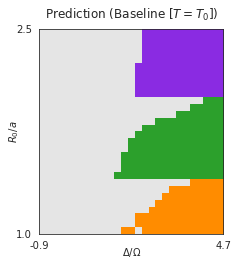

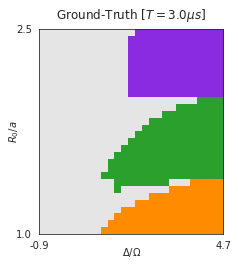

In [35]:
fig_ntk = plot_phase_diagram(dfs_ntk[t],title=f"Prediction (NTK)",hue_order=hue_order,legend_config=legend_config,figsize=figsize,legend=True)
fig_rbf = plot_phase_diagram(dfs_rbf[t],title=f"Prediction (Gaussian Kernel)",hue_order=hue_order,legend_config=legend_config,figsize=figsize)
fig_CGM = plot_phase_diagram(dfs_CGM[t],title=f"Prediction (Ours)",hue_order=hue_order,legend_config=legend_config,figsize=figsize)
fig_dir = plot_phase_diagram(dfs_dir[t],title=f"Prediction (Dirichlet Kernel)",hue_order=hue_order,legend_config=legend_config,figsize=figsize)
fig_base= plot_phase_diagram(get_plot_df(meta_datasets[1.0]),title=r"Prediction (Baseline [$T=T_0$])",hue_order=hue_order,legend_config=legend_config,figsize=figsize)
fig_true= plot_phase_diagram(get_plot_df(meta_datasets[t]),title=f"Ground-Truth [$T=3.0 \mu s$]",hue_order=hue_order,legend_config=legend_config,figsize=figsize,)
fig_ntk.tight_layout()
fig_rbf.tight_layout()
fig_dir.tight_layout()
fig_CGM.tight_layout()
fig_true.tight_layout()

In [36]:
# Save figures

# prefix = root+'figs/paper/2D-time_phase-'
# fig_CGM.savefig(prefix+'ours.pdf')
# fig_true.savefig(prefix+'true.pdf')
# fig_rbf.savefig(prefix+'rbf.pdf')
# fig_ntk.savefig(prefix+'ntk.pdf')
# fig_dir.savefig(prefix+'dir.pdf')
# fig_base.savefig(prefix+'baseline.pdf')